In [1]:
import os
import colorsys
import itertools as it
import numpy as np
import matplotlib.pyplot as plt
from wand.image import Image
from neuron import h, gui, nrn

RUN_LITMUS_TEST = False
RUN_VOLUME_MAP = False

In [2]:
def export(file, ps):
  ps.printfile("tmp.ps")
  with Image(filename="tmp.ps") as img:
    img.save(filename=f"PNG24:{file}")
  os.remove("tmp.ps")

In [3]:
# ps.view takes (mx, my, mw, mh, vx, vy, vw, vh), where m* and v* are for model and view cordinates, respectively.
# Since it conserves aspect ratio, giving zero-height (mh=0) makes model-y (my) to map the middle of the view.
_view = (50, 220, 500, 0, 0, 0, 1600, 1600)

def show_sections(view=_view):
  ps = h.PlotShape(False)
  ps.view(*view)
  ps.show(0)
  return ps

def show_v(view=_view):
  ps = show_sections(size)
  ps.exec_menu("Shape Plot")
  return ps    

In [4]:
class Box:
    def __init__(self):
        self.min = None
        self.max = None

    def __repr__(self):
        return {"min": self.min, "max": self.max}.__repr__()

    def include(self, pt):
        if self.min is None or self.max is None:
            self.min = pt
            self.max = pt
        else:
            self.min = [min(x, y) for x, y in zip(self.min, pt)]
            self.max = [max(x, y) for x, y in zip(self.max, pt)]

In [5]:
class Section:
    _volumes = {}
    
    def diams(self):
        return [self.diam3d(i) for i in range(self.n3d())]

    def points(self):
        return [(self.x3d(i), self.y3d(i), self.z3d(i), self.diam3d(i)) for i in range(self.n3d())]

    def bounding_box(self):
        box = Box()
        for sec in self.subtree():
            for pt in sec.points():
                box.include(pt)
        return box

    def volume(self):
        if self.name not in Section._volumes:
            Section._volumes[self.name] = sum(seg.volume() for seg in self.allseg()) + sum(s.volume() for s in self.children())
        return Section._volumes[self.name]

    def translate(self, v):
        for i, pt in enumerate(self.points()):
            self.pt3dchange(i, *(np.array(pt) + np.array([*v, 0])))

    def round_shape(self):
        x, y, z, d = np.mean(self.points(), axis=0)
        r = d / 2
        self.pt3dclear()

        for dx in np.linspace(-r, r, 256):
            d_ = np.sqrt(r ** 2 - dx ** 2) * 2
            self.pt3dadd(x + dx, y, z, d_)

    def adjust_position(self):
        x, y, z, d = np.mean(self.parentseg().sec.points(), axis=0)
        pt0 = np.array([x, y, z])
        r = d / 2
        pt1 = self.points()[0][0:3]
        diff = pt1 - pt0
        dist = np.sqrt(sum(diff ** 2))
        self.translate(-(1 - r/dist) * diff)

    def traverse(self, pred, f):
        f(self)
        for s in self.children():
            if pred(self, s):
                s.traverse(pred, f)

    def display(self):
        box = self.bounding_box()
        view = (box.min[0], box.min[1], box.max[0], box.max[1], 0, 0, 1200, 1200)
        ps = show_sections(view=view)
        return ps

    def display_v(self):
        ps = self.display()
        ps.exec_menu("Shape Plot")
        return ps


nrn.Section.diams = Section.diams
nrn.Section.points = Section.points
nrn.Section.bounding_box = Section.bounding_box
nrn.Section.volume = Section.volume
nrn.Section.translate = Section.translate
nrn.Section.round_shape = Section.round_shape
nrn.Section.adjust_position = Section.adjust_position
nrn.Section.traverse = Section.traverse
nrn.Section.display = Section.display
nrn.Section.display_v = Section.display_v

In [6]:
def test_continuity(threshold=0.1):
    for sec in h.allsec():
        for i in range(sec.n3d()):
            if sec.diam3d(i) < threshold:
                print('%s %d %g' %  (sec, i, sec.diam3d(i)))

In [7]:
h.load_file("original.hoc")
test_continuity()

In [8]:
soma = next(h.allsec())
trunk = next(x for x in soma.children() if "dend" in x.name())
axon = next(x for x in soma.children() if "axon" in x.name())

soma.round_shape()
trunk.adjust_position()
axon.adjust_position()

In [9]:
def run_litmus():
    ic = h.IClamp(soma(0.5))
    ic.delay = 0
    ic.dur = 3000
    ic.amp = 3

    ps = soma.display_v()
    h.init()
    for t in range(0, 101, 10):
        h.continuerun(t)
        ps.exec_menu("Redraw Shape")
        export(f"litmus/dend_v_{t:03d}.png", ps)
    # Make sure that all the segments have high voltage
    vs = []
    for sec in h.allsec():
      for seg in sec.allseg():
        vs.append(seg.v)

    fig, ax = plt.subplots()
    ax.hist(vs, bins=100)
    plt.show()

if RUN_LITMUS_TEST:
    run_litmus()

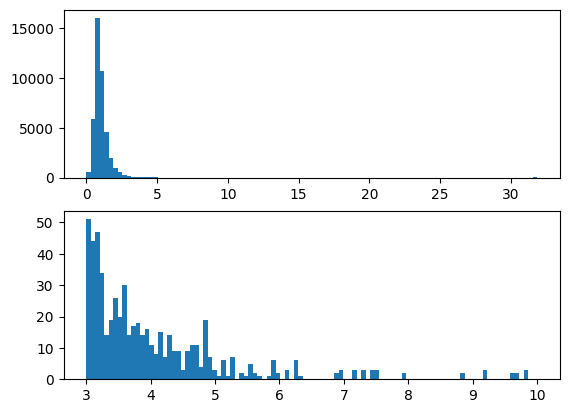

In [10]:
diams = []
for sec in h.allsec():
    for d in sec.diams():
        diams.append(d)

fig, axs = plt.subplots(2)
axs[0].hist(diams, bins=100)
axs[1].hist(diams, bins=100, range=(3,10))
plt.show()

In [11]:
ps = soma.display()
for sec in h.allsec():
  if 2 < sec.diam3d(0):
    ps.color(3, sec=sec)

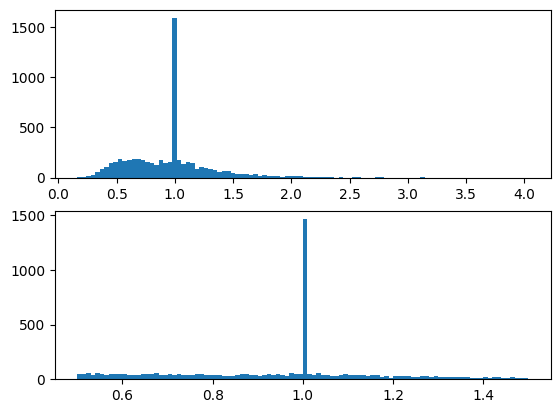

In [12]:
diam_diffs = []
def collect_diam_diffs(sec):
  for s in sec.children():
    diam_diffs.append(max(s.diams()) / max(sec.diams()))
    collect_diam_diffs(s)

collect_diam_diffs(trunk)
fig, axs = plt.subplots(2)
axs[0].hist(diam_diffs, bins=100)
axs[1].hist(diam_diffs, bins=100, range=(0.5, 1.5))
plt.show()

In [13]:
def follow_thickest(f, sec):
  f(sec)
  if 0 < len(sec.children()):
    xs = [np.average(s.diams()) for s in sec.children()]
    i = np.argmax(xs)
    follow_thickest(f, sec.children()[i])

ps = show_sections()
follow_thickest(lambda sec: ps.color(2, sec=sec), trunk)

In [14]:
i = 0
for sec in h.allsec():
  ps.color(i + 2, sec=sec)
  i = (i + 1) % 8

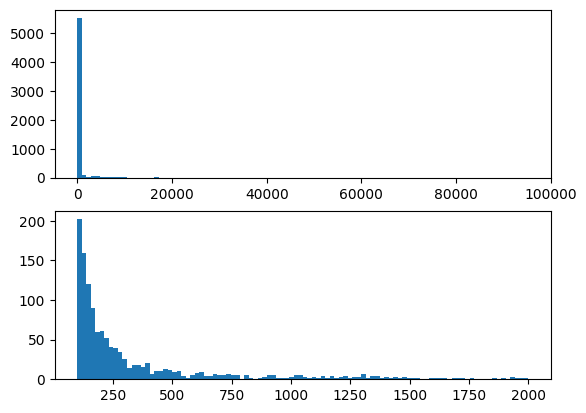

In [15]:
xs = [sec.volume() for sec in h.allsec()]

fig, axs = plt.subplots(2)
axs[0].hist(xs, bins=100)
axs[1].hist(xs, bins=100, range=(100,2000))
plt.show()

In [16]:
def dye_heavy_branches(thr):
    ps = show_sections()
    soma.traverse(lambda _, s: thr < s.volume(), lambda s: ps.color(2, sec=s))
    export(f"volume/{thr}.png", ps)
    return ps

if RUN_VOLUME_MAP:
    for w in range(200, 1201, 200):
        dye_heavy_branches(w)

In [17]:
if RUN_VOLUME_MAP:
    minmax = (100, 1000)
    ps = soma.display_v()
    for sec in h.allsec():
        sec.v = -np.clip(sec.volume(), *minmax)
    soma.v = -minmax[1]
    ps.scale(*(-x for x in reversed(minmax)))
    export(f"volume/{minmax[0]}_{minmax[1]}.png", ps)

In [18]:
branches = []
threshold = 1000
def f(_, x):
    if threshold < x.volume():
        return True
    else:
        branches.append(x)
        return False
trunk.traverse(f, lambda _: 0)

In [19]:
len(branches)

210

In [20]:
num_colors = 16
ps = soma.display_v()
ps.colormap(num_colors + 1)
for i in range(num_colors):
  ps.colormap(i + 1, *(int(x * 256) for x in colorsys.hsv_to_rgb((i / num_colors) % 1.0, 0.7, 0.9)))
def const_true(_p, _c):
    return True
def set_v(v):
    def _f(sec):
        sec.v = v
    return _f
for i, branch in enumerate(branches):
    branch.traverse(const_true, set_v(i % num_colors + 1))
soma.v = 0
axon.traverse(const_true, set_v(0))
ps.scale(0, num_colors)

export("branches.png", ps)